In [13]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from manipulation.station import MakeHardwareStation, load_scenario

from pydrake.all import (
    DiagramBuilder,
    Simulator,
    StartMeshcat,
    ConstantVectorSource
)

# Add the project root to the path so we can import from 'src'
# This assumes you launched the notebook from the 'notebooks' folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import your custom perception module
from src.perception.camera_wrapper import CameraWrapper # noqa: E402

%matplotlib inline
print(f"Project root added: {project_root}")

Project root added: /workspaces/mit-6.4212-belief-space-rrt


In [14]:
meshcat = StartMeshcat()
display(
    HTML(
        f'<h3><a href="{meshcat.web_url()}" target="_blank">Open 3D Visualizer</a></h3>'
    )
)

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [17]:
# 1. Load the Scenario
scenario_path = os.path.join(project_root, "config/scenario.yaml")

with open(scenario_path, "r") as f:
    scenario = load_scenario(data=f.read())

# 2. Build the Station
builder = DiagramBuilder()
station = builder.AddSystem(MakeHardwareStation(scenario=scenario, meshcat=meshcat))

iiwa_position_source = builder.AddSystem(
    ConstantVectorSource(
        np.array([0, 0.1, 0, -1.2, 0, 0.8, 0])  # type: ignore
    )
)

# Connect the source to the station's input port
builder.Connect(
    iiwa_position_source.get_output_port(), station.GetInputPort("iiwa.position")
)

# 4. Create a "Command Source" for the WSG Gripper
# The WSG takes a 1D command (target width in meters).
# 0.1m (10cm) is fully open.
wsg_position_source = builder.AddSystem(ConstantVectorSource([0.1]))  # type: ignore

builder.Connect(
    wsg_position_source.get_output_port(), station.GetInputPort("wsg.position")
)


# 3. Build the Diagram
diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# 4. Setup Perception
# Extract the station context to access camera ports
station_context = diagram.GetMutableSubsystemContext(station, context)
camera = CameraWrapper(station, station_context, camera_name="wrist_camera_sensor")


# 5. Initialize
simulator.set_target_realtime_rate(1.0)
meshcat.StartRecording()

Running simulation from 0.0s to 2.0s...


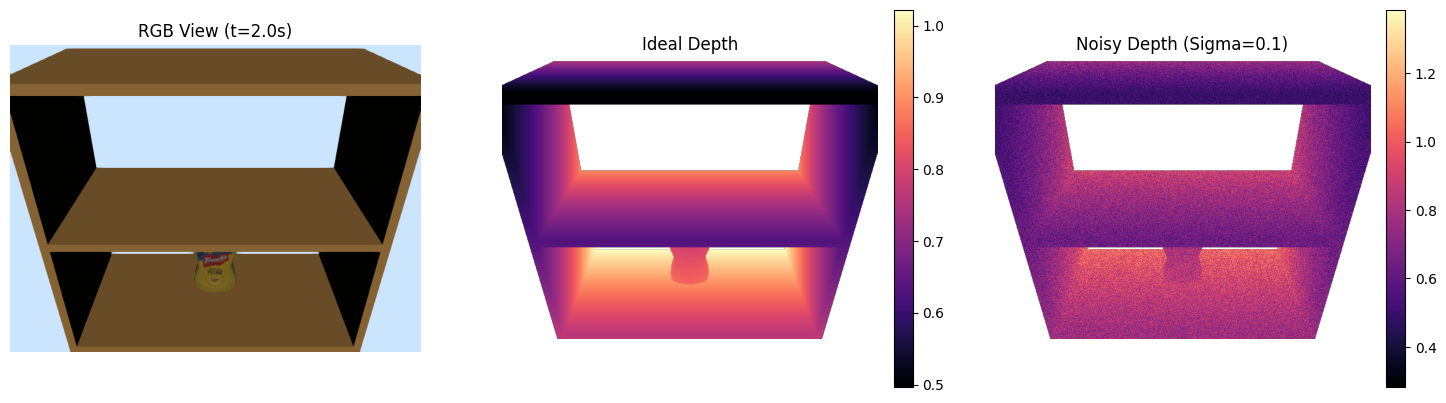

In [18]:
# Run for a short duration
simulation_step = 2.0 # seconds
current_time = context.get_time()

print(f"Running simulation from {current_time:.1f}s to {current_time + simulation_step:.1f}s...")
simulator.AdvanceTo(current_time + simulation_step)

# Capture Data
rgb = camera.get_rgb_image()
depth_ideal = camera.get_depth_image(inject_noise=False)
depth_noisy = camera.get_depth_image(inject_noise=True, sigma=0.1) # 1cm noise

# Visualize Inline
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].imshow(rgb)
ax[0].set_title(f"RGB View (t={context.get_time():.1f}s)")
ax[0].axis('off')

im1 = ax[1].imshow(depth_ideal, cmap='magma')
ax[1].set_title("Ideal Depth")
ax[1].axis('off')
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(depth_noisy, cmap='magma')
ax[2].set_title("Noisy Depth (Sigma=0.1)")
ax[2].axis('off')
plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

plt.show()

* acting to reduce uncertainty
    * creating a "fake" curtain
        * arm can look around it
        * box that is just visual (no collision)
* quadratic noise is decent
* light and dark regions
    * light = ideal sensor
    * dark = bad/very noisy sensor


# baseline
* default RRT
    * 
    